In [2]:
import json

with open("model_outputs/inc_rag_vs_graph.jsonl", 'r') as f:
    irg = [json.loads(x) for x in f]

with open("model_outputs/inc_graph_vs_rag.jsonl", 'r') as f:
    igr = [json.loads(x) for x in f]

with open("model_outputs/full_rag_vs_graph.jsonl", 'r') as f:
    frg = [json.loads(x) for x in f]

with open("model_outputs/full_graph_vs_rag.jsonl", 'r') as f:
    fgr = [json.loads(x) for x in f]

In [3]:
from collections import Counter

Counter(
    [x['verdict'] for x in fgr]
)

Counter({'Both assistants are bad': 102,
         'Both assistants are good': 93,
         'Assistant B is better': 74,
         'Assistant A is better': 50,
         'Assistant A is bad': 2,
         'Assistant A is slightly worse, however, both assistants could only get correct only with further, additional specification. ': 1,
         'Assistant B is worse': 1,
         'Assistant A is worse': 1,
         'Assistant B is bad': 1})

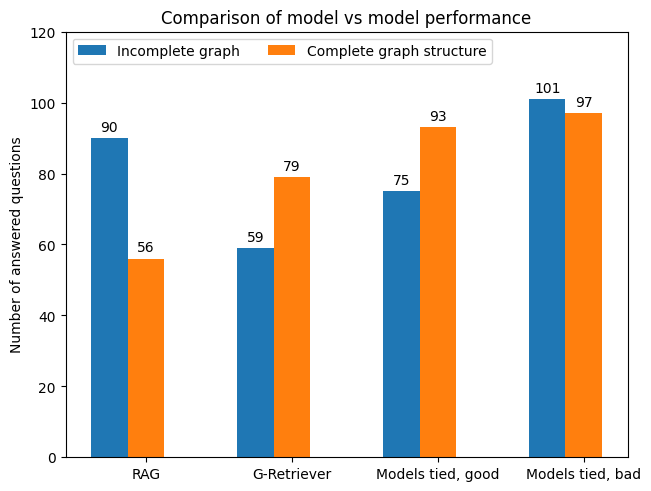

In [10]:
import matplotlib.pyplot as plt
import numpy as np

verdicts = ("RAG", "G-Retriever", "Models tied, good", "Models tied, bad")
values = {
    # The values are hardcoded because the scores are not consistent (see previous code block)
    'Incomplete graph': (90, 59, 75, 101),
    'Complete graph structure': (56, 79, 93, 97),
}

x = np.arange(len(verdicts))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of answered questions')
ax.set_title('Comparison of model vs model performance')
ax.set_xticks(x + width, verdicts)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 120)

plt.show()

In [11]:
import json

with open("model_outputs/abs_incomp_rag.jsonl", 'r') as f:
    ir = [json.loads(x) for x in f]

with open("model_outputs/abs_incomp_graph.jsonl", 'r') as f:
    ig = [json.loads(x) for x in f]

with open("model_outputs/abs_full_rag.jsonl", 'r') as f:
    fr = [json.loads(x) for x in f]

with open("model_outputs/abs_full_graph.jsonl", 'r') as f:
    fg = [json.loads(x) for x in f]

In [12]:
scores_ir = dict(Counter([int(x['score']) for x in ir]))
scores_ig = dict(Counter([int(x['score']) for x in ig]))
scores_fr = dict(Counter([int(x['score']) for x in fr]))
scores_fg = dict(Counter([int(x['score']) for x in fg]))

results = list()
for score_list in [scores_ir, scores_ig, scores_fr, scores_fg]:
    for score in range(11):
        if score not in score_list:
            score_list[score] = 0
    score_list = list(score_list.items())
    score_list.sort(key=lambda l:l[0])
    score_list = [x[1] for x in score_list]
    results.append(score_list)

scores_ir, scores_ig, scores_fr, scores_fg = results

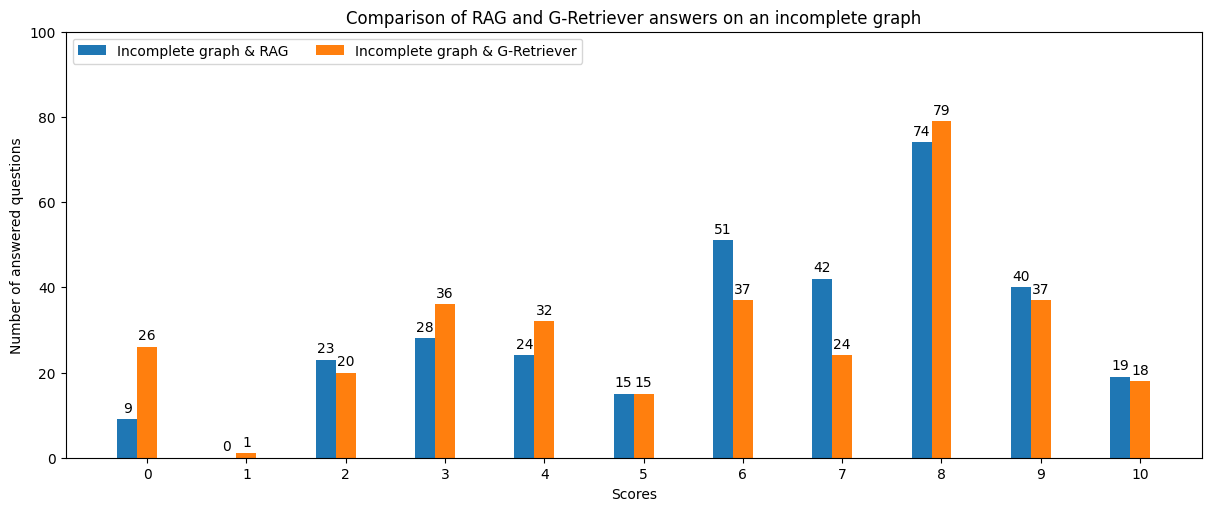

In [13]:
import matplotlib.pyplot as plt
import numpy as np

scores = range(11)
values = {
    'Incomplete graph & RAG': scores_ir,
    'Incomplete graph & G-Retriever': scores_ig,
    # 'Complete graph & RAG': scores_fr,
    # 'Complete graph & G-Retriever': scores_fg
}

x = np.arange(len(scores))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 5))

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of answered questions')
ax.set_xlabel("Scores")
ax.set_title('Comparison of RAG and G-Retriever answers on an incomplete graph')
ax.set_xticks(x + width, scores)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()

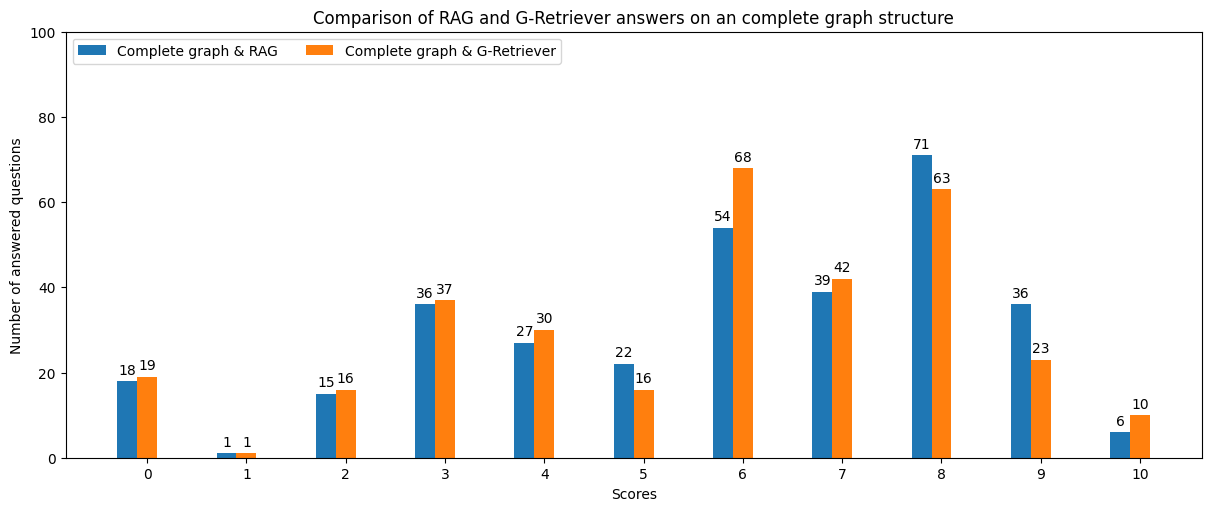

In [14]:
import matplotlib.pyplot as plt
import numpy as np

scores = range(11)
values = {
    # 'Incomplete graph & RAG': scores_ir,
    # 'Incomplete graph & G-Retriever': scores_ig,
    'Complete graph & RAG': scores_fr,
    'Complete graph & G-Retriever': scores_fg
}

x = np.arange(len(scores))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 5))

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of answered questions')
ax.set_xlabel("Scores")
ax.set_title('Comparison of RAG and G-Retriever answers on an complete graph structure')
ax.set_xticks(x + width, scores)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

plt.show()